In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy



def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

#want to look at a single neuron in the attention layer, and look at its with the neurons in the input layers. syspect that there will
#be a subset of neurons that are particularly predictive of the attention layers activity. 

#will need  to see how th e neuron correlates with the inputs when attnetion is left or right, from the left and riht layer
input_neurons = np.arange(0, 160)
attention_neurons = np.arange(0, 1)

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
structure = {f'dataset_{file_number}': {f'attneuron_{att_neuron}': {f'input_neuron_{input_neuron}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for input_neuron in input_neurons} for att_neuron in attention_neurons} for file_number in file_numbers}

pearson_results_raw = copy.deepcopy(structure)
pearson_errors_raw = copy.deepcopy(structure)

pearson_results_nopre = copy.deepcopy(structure)
pearson_errors_nopre = copy.deepcopy(structure)


total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_nopre = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    left_input_SP = data['SP'][0][0] 
    right_input_SP = data['SP'][0][1]
    attention_SP = data['SP'][0][2]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    # left_input_SP (2032, 500, 160)
    # right_input_SP (2032, 500, 160)
    # attention_SP (2032, 500, 80)
    

    # attend_left_not_omitted = np.where((data["attend"][0] == 0) & (data["omit"][0] == 0) & (label_left != label_right))[0]
    # attend_right_not_omitted = np.where((data["attend"][0] == 1) & (data["omit"][0] == 0) & (label_left != label_right))[0]

    attend_left_not_omitted = np.where((data["attend"][0] == 0) & (data["omit"][0] == 0))[0]
    attend_right_not_omitted = np.where((data["attend"][0] == 1) & (data["omit"][0] == 0))[0]

    left_input_attendingleft_t = left_input_SP[attend_left_not_omitted, 100:350, :]
    right_input_attendingleft_t = right_input_SP[attend_left_not_omitted, 100:350, :]
    attention_layer_attendingleft_t = attention_SP[attend_left_not_omitted, 100:350, :]

    left_input_attendingright_t = left_input_SP[attend_right_not_omitted, 100:350, :]
    right_input_attendingright_t = right_input_SP[attend_right_not_omitted, 100:350, :]
    attention_layer_attendingright_t = attention_SP[attend_right_not_omitted, 100:350, :]

    #eft_input_attendingleft_t (468, 250, 160) (80 for attention)
    #left_input_attendingright_t (536, 250, 160) (80 for attention)

    # sigma = 2

    # left_in_attleft_sm = smooth_with_gaussian(left_input_attendingleft_t, sigma=sigma) 
    # right_in_attleft_sm = smooth_with_gaussian(right_input_attendingleft_t, sigma=sigma) 
    # attlay_attleft_sm = smooth_with_gaussian(attention_layer_attendingleft_t, sigma=sigma) 

    # left_in_attright_sm = smooth_with_gaussian(left_input_attendingright_t, sigma=sigma) 
    # right_in_attright_sm = smooth_with_gaussian(right_input_attendingright_t, sigma=sigma)
    # attlay_attright_sm = smooth_with_gaussian(attention_layer_attendingright_t, sigma=sigma)

    sigma = 2

    left_in_attleft_sm = left_input_attendingleft_t 
    right_in_attleft_sm = right_input_attendingleft_t
    attlay_attleft_sm = attention_layer_attendingleft_t

    left_in_attright_sm = left_input_attendingright_t
    right_in_attright_sm = right_input_attendingright_t
    attlay_attright_sm = attention_layer_attendingright_t



    num_trials_left, num_samples, num_neurons_left = left_input_attendingleft_t.shape
    num_trials_right = left_input_attendingright_t.shape[0]
    num_neurons_attention = 80

            
    for j in range(0, num_trials_left):
        for i in range(0, num_neurons_left):
            count_left = np.count_nonzero(left_input_attendingleft_t[j, :, i] == 1)
            if count_left > 0:
                left_in_attleft_sm[j, :, i] /= count_left            # this normalises each trial by the number of spikes in the trial
            count_right = np.count_nonzero(right_input_attendingleft_t[j, :, i] == 1)
            if count_right > 0:
                right_in_attleft_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_layer_attendingleft_t[j, :, i] == 1)
            if count_attention > 0:
                attlay_attleft_sm[j, :, i] /= count_attention



    for j in range(0, num_trials_right):
        for i in range(0, num_neurons_left):
            count_left = np.count_nonzero(left_input_attendingright_t[j, :, i] == 1)
            if count_left > 0:
                left_in_attright_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_attendingright_t[j, :, i] == 1)
            if count_right > 0:
                right_in_attright_sm[j, :, i] /= count_right    

        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_layer_attendingright_t[j, :, i] == 1)
            if count_attention > 0:
                attlay_attright_sm[j, :, i] /= count_attention

#so here each trial for each neuron has been normalised by the number of spikes. still have (n_trials, n_times, n_neurons) shape
    left_input_SP_attleft = left_in_attleft_sm
    right_input_SP_attleft = right_in_attleft_sm
    attention_SP_attleft = attlay_attleft_sm

    left_input_SP_attright = left_in_attright_sm
    right_input_SP_attright = right_in_attright_sm
    attention_SP_attright = attlay_attright_sm

    ##these have shapes(trials, times, neurons)
    #plt.plot(left_input_SP_attleft[0])
    #plt.show()
    # print(np.mean(left_input_SP_attleft, axis=0).shape)
    # plt.plot(np.mean(left_input_SP_attleft, axis=0)[:, 0])
    # plt.show()

    # print(np.mean(attention_SP_attleft, axis=0).shape)
    # plt.plot(np.mean(attention_SP_attleft, axis=0)[:, 0])
    # plt.show()

    #----------------no preprocessing--------------------------------
    for i in range(len(attention_neurons)):
        for j in range(len(input_neurons)):
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['left_attleft'] = \
                pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['right_attleft'] = \
                pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
            
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['left_attright'] = \
                pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['right_attright'] = \
                pearsonr(np.mean(right_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
            
    print(f'time for no preprocessing in file {file_number} =', time.time() - file_nopre)
    process_time = time.time()



    #---------------- preprocessing the data ----------------------------------------NB detrending first to avoid 0 and NaN values
    if len(attend_left_not_omitted) >= 1:
        left_input_SP_attleft = detrend(left_input_SP_attleft, axis=0)
        right_input_SP_attleft = detrend(right_input_SP_attleft, axis=0)
        attention_SP_attleft = detrend(attention_SP_attleft, axis=0)

    if len(attend_right_not_omitted) >= 1:
        left_input_SP_attright = detrend(left_input_SP_attright, axis=0)
        right_input_SP_attright = detrend(right_input_SP_attright, axis=0)
        attention_SP_attright = detrend(attention_SP_attright, axis=0)

    for i in range(len(left_input_SP_attleft)):
        left_input_SP_attleft[i] = detrend(left_input_SP_attleft[i])
        right_input_SP_attleft[i] = detrend(right_input_SP_attleft[i])
        attention_SP_attleft[i] = detrend(attention_SP_attleft[i])

    for i in range(len(left_input_SP_attright)):
        left_input_SP_attright[i] = detrend(left_input_SP_attright[i])
        right_input_SP_attright[i] = detrend(right_input_SP_attright[i])
        attention_SP_attright[i] = detrend(attention_SP_attright[i])

    if len(attend_left_not_omitted) > 2:
        left_input_SP_attleft = zscore(left_input_SP_attleft, axis=0)
        right_input_SP_attleft = zscore(right_input_SP_attleft, axis=0)
        attention_SP_attleft = zscore(attention_SP_attleft, axis=0)

    if len(attend_right_not_omitted) > 2:
        left_input_SP_attright = zscore(left_input_SP_attright, axis=0)
        right_input_SP_attright = zscore(right_input_SP_attright, axis=0)
        attention_SP_attright = zscore(attention_SP_attright, axis=0)

    #plt.plot(left_input_SP_attleft[0])
    #plt.show()


    #----------------------------------------------------------------
    for i in range(len(attention_neurons)):
        for j in range(len(input_neurons)):
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['left_attleft'] = \
                pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['right_attleft'] = \
                pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
            
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['left_attright'] = \
                pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
            pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{attention_neurons[i]}'][f'input_neuron_{input_neurons[j]}']['right_attright'] = \
                pearsonr(np.mean(right_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
            
    print(f'time to process preprocessed file = {file_number} =', time.time() - process_time)
          
    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(pearson_results_raw)


Dataset 1 loaded in 12.85 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(le

time for no preprocessing in file 1 = 30.73140048980713
Dataset 1 complete in 54.98007917404175
Dataset 2 loaded in 6.92 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(le

time for no preprocessing in file 2 = 25.30849575996399
Dataset 2 complete in 47.67160129547119
Dataset 4 loaded in 8.51 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(rig

time for no preprocessing in file 4 = 27.48627781867981
Dataset 4 complete in 52.97423791885376
Dataset 8 loaded in 8.28 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(rig

time for no preprocessing in file 8 = 28.093296766281128
Dataset 8 complete in 53.92999005317688
Dataset 14 loaded in 9.93 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(le

time for no preprocessing in file 14 = 28.764463186264038
Dataset 14 complete in 68.886883020401
Dataset 15 loaded in 15.03 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(rig

time for no preprocessing in file 15 = 40.13001751899719
Dataset 15 complete in 64.48333978652954
Dataset 20 loaded in 8.53 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(rig

time for no preprocessing in file 20 = 29.117811918258667
Dataset 20 complete in 61.32905983924866
Dataset 23 loaded in 12.56 seconds


C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:156: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:158: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(right_input_SP_attleft, axis = 0)[:, j], np.mean(attention_SP_attleft, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:161: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(left_input_SP_attright, axis = 0)[:, j], np.mean(attention_SP_attright, axis = 0)[:, i])[0]
C:\Users\joshu\AppData\Local\Temp\ipykernel_7032\1993284090.py:163: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(np.mean(rig

time for no preprocessing in file 23 = 31.19841718673706
Dataset 23 complete in 57.047953367233276
total time elapsed = 461.3152129650116
{'dataset_1': {'attneuron_0': {'input_neuron_0': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_1': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_2': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_3': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_4': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_5': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_6': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []}, 'input_neuron_7': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []},

c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\joshu\nice\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


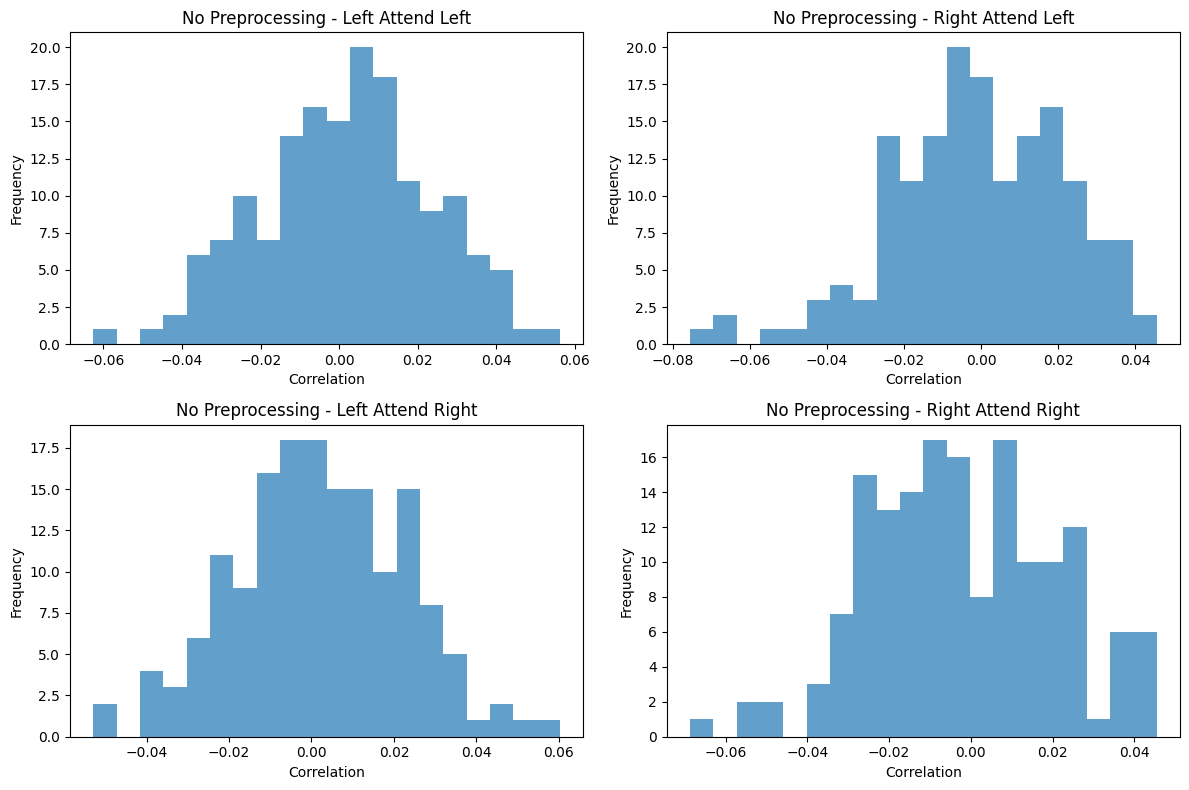

[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(na

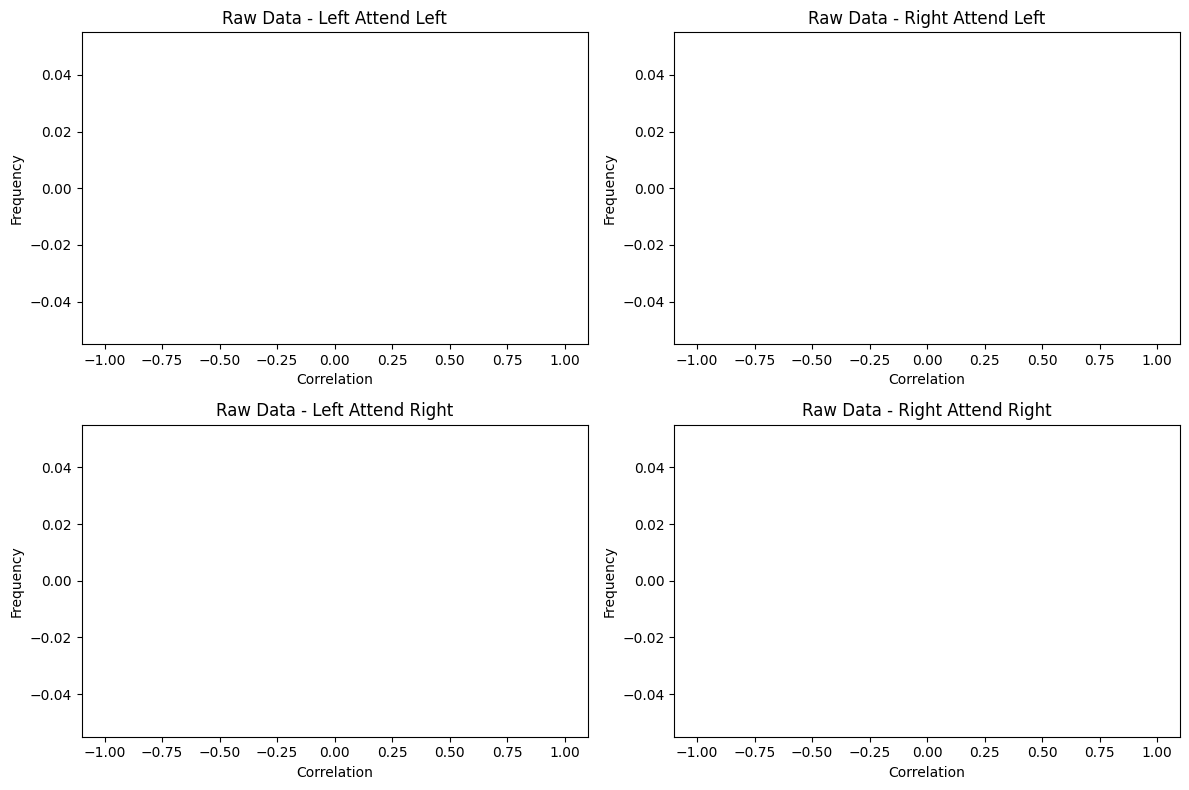

In [27]:
#now want to histogram these correlations. will firs take means across all datasets, then plot histograms for each input neuron

mean_correlations_raw = {f'attneuron_{att_neuron}': {f'input_neuron_{input_neuron}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for input_neuron in input_neurons} for att_neuron in attention_neurons}

mean_correlations_nopre = {f'attneuron_{att_neuron}': {f'input_neuron_{input_neuron}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for input_neuron in input_neurons} for att_neuron in attention_neurons}

for att_neuron in attention_neurons:
    for input_neuron in input_neurons:
        mean_correlations_raw[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attleft'] = np.mean([pearson_results_raw[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attleft'] for file_number in file_numbers])
        mean_correlations_raw[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attleft'] = np.mean([pearson_results_raw[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attleft'] for file_number in file_numbers])
        mean_correlations_raw[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attright'] = np.mean([pearson_results_raw[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attright'] for file_number in file_numbers])
        mean_correlations_raw[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attright'] = np.mean([pearson_results_raw[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attright'] for file_number in file_numbers])

        mean_correlations_nopre[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attleft'] = np.mean([pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attleft'] for file_number in file_numbers])
        mean_correlations_nopre[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attleft'] = np.mean([pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attleft'] for file_number in file_numbers])
        mean_correlations_nopre[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attright'] = np.mean([pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['left_attright'] for file_number in file_numbers])
        mean_correlations_nopre[f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attright'] = np.mean([pearson_results_nopre[f'dataset_{file_number}'][f'attneuron_{att_neuron}'][f'input_neuron_{input_neuron}']['right_attright'] for file_number in file_numbers])

#plotting histogram for attention neuron 0, all input neurons
# Extracting the correlations for attneuron_0 with all input neurons
correlations_nopre_left_attleft = [mean_correlations_nopre['attneuron_0'][f'input_neuron_{input_neuron}']['left_attleft'] for input_neuron in input_neurons]
correlations_nopre_right_attleft = [mean_correlations_nopre['attneuron_0'][f'input_neuron_{input_neuron}']['right_attleft'] for input_neuron in input_neurons]
correlations_nopre_left_attright = [mean_correlations_nopre['attneuron_0'][f'input_neuron_{input_neuron}']['left_attright'] for input_neuron in input_neurons]
correlations_nopre_right_attright = [mean_correlations_nopre['attneuron_0'][f'input_neuron_{input_neuron}']['right_attright'] for input_neuron in input_neurons]

# Plotting histograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(correlations_nopre_left_attleft, bins=20, alpha=0.7)
plt.title('No Preprocessing - Left Attend Left')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(correlations_nopre_right_attleft, bins=20, alpha=0.7)
plt.title('No Preprocessing - Right Attend Left')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(correlations_nopre_left_attright, bins=20, alpha=0.7)
plt.title('No Preprocessing - Left Attend Right')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(correlations_nopre_right_attright, bins=20, alpha=0.7)
plt.title('No Preprocessing - Right Attend Right')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Extracting the correlations for attneuron_0 with all input neurons for raw data
correlations_raw_left_attleft = [mean_correlations_raw['attneuron_0'][f'input_neuron_{input_neuron}']['left_attleft'] for input_neuron in input_neurons]
correlations_raw_right_attleft = [mean_correlations_raw['attneuron_0'][f'input_neuron_{input_neuron}']['right_attleft'] for input_neuron in input_neurons]
correlations_raw_left_attright = [mean_correlations_raw['attneuron_0'][f'input_neuron_{input_neuron}']['left_attright'] for input_neuron in input_neurons]
correlations_raw_right_attright = [mean_correlations_raw['attneuron_0'][f'input_neuron_{input_neuron}']['right_attright'] for input_neuron in input_neurons]


print(correlations_raw_left_attleft)
# Plotting histograms for raw data
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(correlations_raw_left_attleft, bins=20, alpha=0.7, range = (-1, 1))

plt.title('Raw Data - Left Attend Left')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(correlations_raw_right_attleft, bins=20, alpha=0.7, range = (-1, 1))
plt.title('Raw Data - Right Attend Left')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(correlations_raw_left_attright, bins=20, alpha=0.7, range = (-1, 1))
plt.title('Raw Data - Left Attend Right')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(correlations_raw_right_attright, bins=20, alpha=0.7, range = (-1, 1))
plt.title('Raw Data - Right Attend Right')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
